In [155]:
import muon as mu
import anndata as ad
import scanpy as sc
from tqdm import tqdm
import scipy as sp
import numpy as np
import pandas as pd
import pysam
import matplotlib.pyplot as plt
import sklearn

import ctar
# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [164]:
data_path = '/projects/zhanglab/users/ana/multiome/'
mdata = mu.read(data_path+'processed/brain_3k/brain3k_processed.h5mu') 
print(mdata['rna'])
print(mdata['atac'])

AnnData object with n_obs × n_vars = 2894 × 36601
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'lognorm'
    obsp: 'connectivities', 'distances'
AnnData object with n_obs × n_vars = 2894 × 84598
    obs: 'n_genes_by_counts', 'total_counts', 'nucleosome_signal', 'tss_score', 'leiden', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'atac', 'celltype_

In [165]:
rna_adata = mdata['rna']
atac_adata = mdata['atac']

### Testing functions

In [166]:
atac_adata.X = atac_adata.X.astype(float)
mu.atac.tl.lsi(atac_adata)
print(atac_adata.obsm['X_lsi'].shape, # by cells
      atac_adata.varm['LSI'].shape # by peaks
     )

(2894, 50) (84598, 50)


In [183]:
genes_df = rna_adata.var.copy()
y_pred = ctar.chromatin_potential.gene_activity(atac_adata, genes_df)

100%|██████████| 36588/36588 [02:15<00:00, 269.30it/s]


In [186]:
rna_adata = rna_adata[:,y_pred.var_names].copy()

In [187]:
y_obs, y_pred = ctar.chromatin_potential.smooth_vals(atac_adata, rna_adata, y_pred)

(2894, 36588) (2894, 36588)


In [188]:
dists, neighs = ctar.chromatin_potential.chrom_potential(y_obs, y_pred)

scaled values
obtained neighbors


In [193]:
dij, embed_, embed_projected = ctar.chromatin_potential.embed_arrows(dists, neighs, atac_adata)

100%|██████████| 2894/2894 [00:26<00:00, 109.35it/s]

obtained distances


Text(0.5, 1.0, 'LSI mapping')

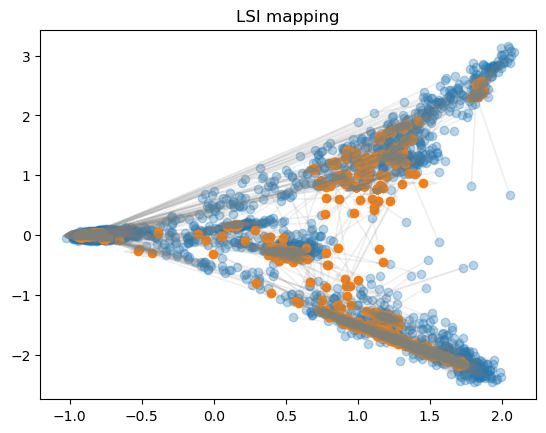

In [201]:
plt.scatter(embed_[:,0],embed_[:,1],alpha=0.3);
plt.scatter(embed_projected[:,0],embed_projected[:,1],alpha=1);
for i in range(embed_projected.shape[0]):
    dx = embed_[i, 0] - embed_projected[i, 0]
    dy = embed_[i, 1] - embed_projected[i, 1]
    plt.arrow(embed_[i, 0], embed_[i, 1], -dx, -dy, 
              color='gray', alpha=0.1, head_width=0.1, head_length=0.1)
plt.title('LSI mapping')

In [207]:
dij, embed_, embed_projected = ctar.chromatin_potential.embed_arrows(dists, neighs, rna_adata, embed='umap')

100%|██████████| 2894/2894 [00:00<00:00, 137810.12it/s]


smoothing in umap


100%|██████████| 2894/2894 [00:23<00:00, 123.53it/s]

obtained distances


Text(0.5, 1.0, 'UMAP mapping')

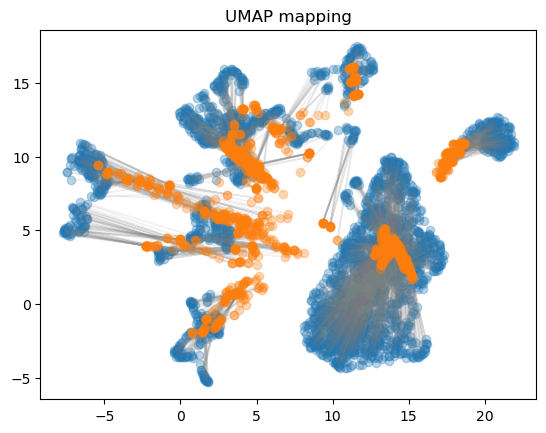

In [213]:
plt.scatter(embed_[:,0],embed_[:,1],alpha=0.3);
for i in range(embed_projected.shape[0]):
    dx = embed_[i, 0] - embed_projected[i, 0]
    dy = embed_[i, 1] - embed_projected[i, 1]
    plt.arrow(embed_[i, 0], embed_[i, 1], -dx, -dy, 
              color='gray', alpha=0.1, head_width=0.1, head_length=0.1)
plt.scatter(embed_projected[:,0],embed_projected[:,1],alpha=0.3);
plt.title('UMAP mapping')

In [ ]:
ax = sc.pl.umap(rna_adata, color=['celltype'],show=False)
ax.scatter(embed_projected[:,0],embed_projected[:,1],s=2,color='grey');
for i in range(embed_projected.shape[0]):
    dx = embed_[i, 0] - embed_projected[i, 0]
    dy = embed_[i, 1] - embed_projected[i, 1]
    ax.arrow(embed_[i, 0], embed_[i, 1], -dx, -dy, 
              color='gray', alpha=0.1, head_width=0.1, head_length=0.1)
ax.set_title('UMAP mapping')

### (Old code) Exploration

In [68]:
genes_df = rna_adata.var.copy()
genes_df[['Chromosome','start','end']] = genes_df.interval.str.split(':|-',expand=True)
genes_df = genes_df[~genes_df.start.isna()].copy()
genes_df[['start','end']] = genes_df[['start','end']].astype(int)

In [70]:
y_pred = mu.atac.tl.count_fragments_features(mdata,features=genes_df,extend_upstream=2000)
y_pred

100%|██████████| 36588/36588 [04:35<00:00, 132.86it/s]


AnnData object with n_obs × n_vars = 2894 × 36588
    obs: 'n_genes_by_counts', 'total_counts', 'nucleosome_signal', 'tss_score', 'leiden', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'chr', 'start', 'end', 'Chromosome'

In [94]:
rna_adata

AnnData object with n_obs × n_vars = 2894 × 36601
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'chr', 'start', 'end', 'Chromosome'
    uns: 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'lognorm'
    obsp: 'connectivities', 'distances'

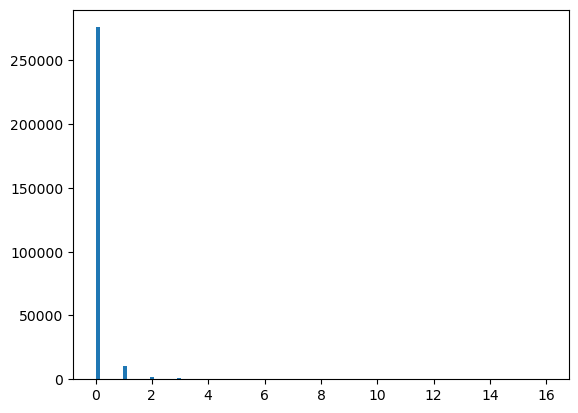

In [96]:
plt.hist(rna_adata.layers['counts'][:,:100].toarray().flatten(),bins=100);

(0.0, 10.0)

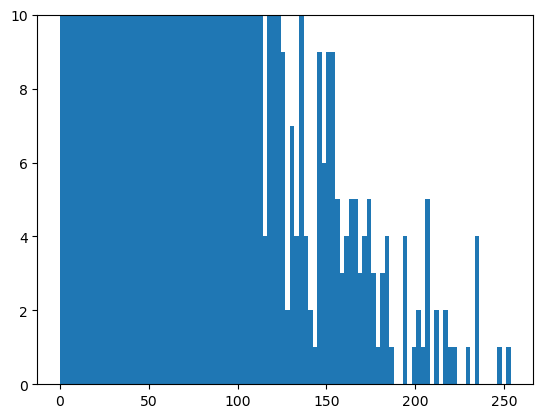

In [106]:
# compare distribution to a regular rna
plt.hist(y_pred.X[:,:1000].toarray().flatten(),bins=100);
plt.ylim(0,10)

(0.0, 10.0)

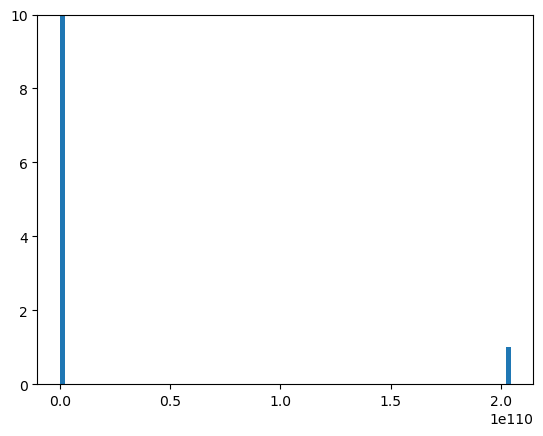

In [107]:
plt.hist(np.exp(y_pred.X[:,:1000].toarray().flatten()),bins=100);
plt.ylim(0,10)

In [109]:
y_pred.X = y_pred.X.astype(np.float64)

In [110]:
sc.pp.normalize_per_cell(y_pred)
sc.pp.log1p(y_pred)

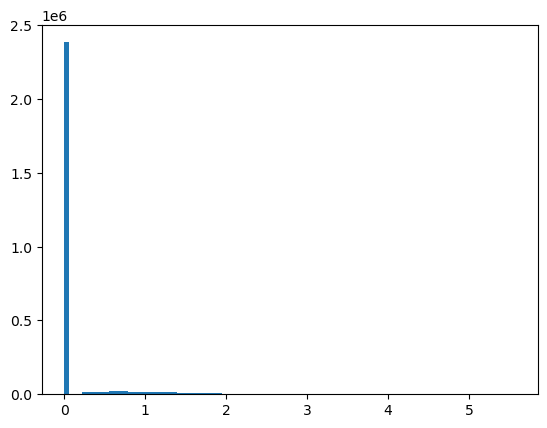

In [116]:
plt.hist(y_pred.X[:,:1000].toarray().flatten(),bins=100);

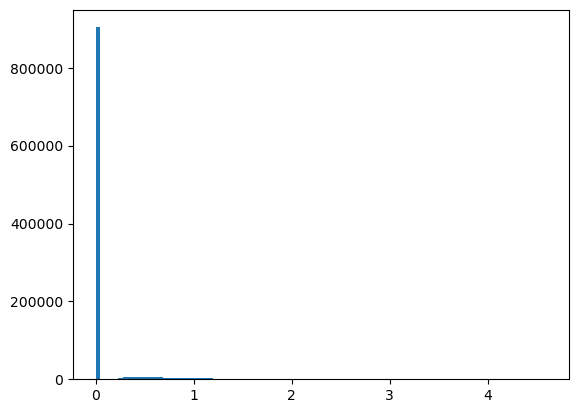

In [123]:
plt.hist(rna_adata.layers['lognorm'][:,:1000].toarray().flatten(),bins=100);

In [130]:
sc.pp.scale(y_pred, max_value=10)

(-2.0, 10.0)

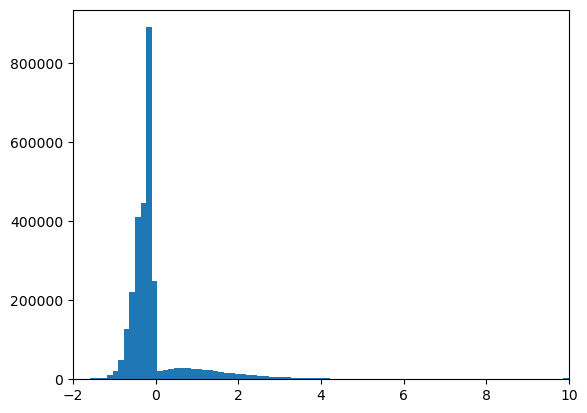

In [135]:
plt.hist(y_pred.X[:,:1000].flatten(),bins=100);
plt.xlim(-2,10)

(1.0, 100000.0)

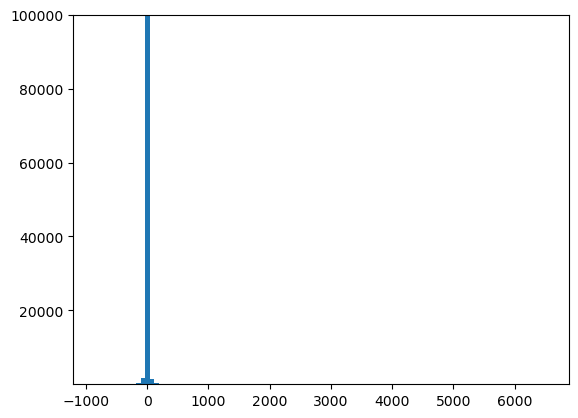

In [141]:
plt.hist(rna_adata.X[:,:1000].flatten(),bins=100);
plt.ylim(1,1e5)